# Individual household electric power consumption Data Set cleaning
The set is taken from here: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#

The file has extention .txt and it contains a semicolon delimited table with a header.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta

## Data download and initial check
Let us to download the data, look at first rows and check dimensions.

In [2]:
power_consumption = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
power_consumption.head(), power_consumption.shape

(         Date      Time Global_active_power Global_reactive_power  Voltage  \
 0  16/12/2006  17:24:00               4.216                 0.418  234.840   
 1  16/12/2006  17:25:00               5.360                 0.436  233.630   
 2  16/12/2006  17:26:00               5.374                 0.498  233.290   
 3  16/12/2006  17:27:00               5.388                 0.502  233.740   
 4  16/12/2006  17:28:00               3.666                 0.528  235.680   
 
   Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
 0           18.400          0.000          1.000            17.0  
 1           23.000          0.000          1.000            16.0  
 2           23.000          0.000          2.000            17.0  
 3           23.000          0.000          1.000            17.0  
 4           15.800          0.000          1.000            17.0  ,
 (2075259, 9))

As we see the table has 2 million
rows, and the date column has European standard: a day number before a month number.

What are our columns types?

In [3]:
power_consumption.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

What is a range for the numbers of records for a day?

In [4]:
number_of_entries_per_day = dict()
for day in power_consumption.Date:
    if day in number_of_entries_per_day:
        number_of_entries_per_day[day] +=1
    else:
        number_of_entries_per_day[day] = 1

frequences = number_of_entries_per_day.values()
min(frequences), max(frequences)

(396, 1440)

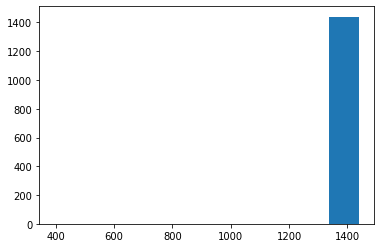

In [5]:
plt.hist(frequences, bins=10)
plt.show()


As we see a vast majority of days have about the same amount of records. 

How uniformly our observations are distributed during 24-hour period?

In [6]:
number_of_entries_per_day_and_hour = dict()
for day, entry in zip(power_consumption.Date, power_consumption.Time):
    hour = entry[:2]
    if (day,hour) in number_of_entries_per_day_and_hour:
        number_of_entries_per_day_and_hour[(day,hour)] +=1
    else:
        number_of_entries_per_day_and_hour[(day,hour)] = 1

frequences = number_of_entries_per_day_and_hour.values()
min(frequences), max(frequences)

(3, 60)

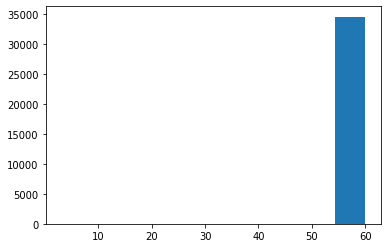

In [7]:
plt.hist(frequences, bins=10)
plt.show()

The next question is: do we have any missing days? 

We can figure out that years for our data are 2006, 2007, 2008, 2009, 2010, because the first year is 2006 and we have 47 month of data. Recall that a year in our `Date` column takes last 4 places.

In [8]:
days_in_a_year = {2006: (0), 2007:(0), 2008: (0), 2009:(0), 2010:(0)}

for day in number_of_entries_per_day:
    year = int(day[-4:])
    days_in_a_year[year] += 1

days_in_a_year

{2006: 16, 2007: 365, 2008: 366, 2009: 365, 2010: 330}

Clearly we are fine with years 2007, 2008, 2009. We are good even with 2006 if we think about it: the only days for it are in December, and here are 31 days in the month. We start our records from 16th, so 15 days in December were without records, and 31-15 = 16. The year 2010 is more complicated. But we can get enumeration of year days in our data for the year, and check if the list contains all intermediate numbers.

In [9]:
year2010days = [pd.to_datetime(date).strftime('%j') for date  in number_of_entries_per_day.keys() if date[-4:] == '2010']
min(year2010days), max(year2010days)

('001', '345')

We obviously have some missing days. Let us see which ones. 

In [10]:
missing_dates = list(range(1, 346))
for i in year2010days:
        missing_dates.remove(int(i))

print("A number of missing days in 2010 is {}. Here they are:".format(len(missing_dates)))
missing_dates.sort()
first_day_2010 = date(2010, 1, 1)
for i in missing_dates:
    print((first_day_2010 + timedelta(days=i-1)).strftime("%A %d, %B %Y"))

print("The last day of recording is {}.".format((first_day_2010 + timedelta(days=344)).strftime("%A %d, %B %Y")))

A number of missing days in 2010 is 15. Here they are:
Tuesday 12, January 2010
Friday 12, February 2010
Friday 12, March 2010
Monday 12, April 2010
Wednesday 12, May 2010
Saturday 12, June 2010
Monday 12, July 2010
Thursday 12, August 2010
Sunday 12, September 2010
Tuesday 12, October 2010
Friday 12, November 2010
Saturday 27, November 2010
Sunday 28, November 2010
Monday 29, November 2010
Tuesday 30, November 2010
The last day of recording is Saturday 11, December 2010.


Something strange with 12th day of a month. And a few days in the end of the November are missing. 

What is the proportion with respect to the total number of days?

In [15]:
15/(16+365+366+365+330)

0.010402219140083218

So we have 1% more of missing data, above declared 1.25% in the data description. Still it is not very much, unless we decide to investigate what happens each month of year 2010.

## Conversion into Date and Time types.

It looks like our Date and Time columns do not have missing values, or the previous cells would fail. I will transform them into Python date and time types, correspondingly. In addition I can create a timestamp column.

In [11]:
power_consumption["Date"] = pd.to_datetime(power_consumption["Date"])
power_consumption["Time"] = pd.to_timedelta(power_consumption["Time"])
power_consumption["Timestamp"] = power_consumption["Date"] + power_consumption["Time"]

## Missing values as NaN
I will calculate missing values for each column.

In [12]:
power_consumption.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
Timestamp                    0
dtype: int64

We see missing values in the last column. 

## Discovery of masked missing values and their consequent replacement with NaNs.

Now I need to change data types so I can use them as numeric values. I will start with numerical values.

In [13]:
cols = list(power_consumption.columns)
cols.remove('Date'), cols.remove('Time'), cols.remove('Timestamp'), cols.remove('Sub_metering_3')

for col in cols:
    power_consumption[col] = pd.to_numeric(power_consumption[col])

ValueError: Unable to parse string "?" at position 6839

I see a non-numerical value in the table, "?". It appears at row 6839. Let us look at the row.

In [16]:
power_consumption.iloc[6839, :]

Date                     2006-12-21 00:00:00
Time                         0 days 11:23:00
Global_active_power                        ?
Global_reactive_power                      ?
Voltage                                    ?
Global_intensity                           ?
Sub_metering_1                             ?
Sub_metering_2                             ?
Sub_metering_3                           NaN
Timestamp                2006-12-21 11:23:00
Name: 6839, dtype: object

Alas, here are more missing values. They are masked as '?'. I would rather have `NaN` instead. 

In [17]:
power_consumption = power_consumption.replace('?', np.NaN)
power_consumption.isnull().sum(), power_consumption.iloc[6839, :]

(Date                         0
 Time                         0
 Global_active_power      25979
 Global_reactive_power    25979
 Voltage                  25979
 Global_intensity         25979
 Sub_metering_1           25979
 Sub_metering_2           25979
 Sub_metering_3           25979
 Timestamp                    0
 dtype: int64, Date                     2006-12-21 00:00:00
 Time                         0 days 11:23:00
 Global_active_power                      NaN
 Global_reactive_power                    NaN
 Voltage                                  NaN
 Global_intensity                         NaN
 Sub_metering_1                           NaN
 Sub_metering_2                           NaN
 Sub_metering_3                           NaN
 Timestamp                2006-12-21 11:23:00
 Name: 6839, dtype: object)

Let us see what is a proportion of rows with missing values.

In [18]:
25979/2075259

0.012518437457686004

So these are 1.25% of missing values about which we read on the data set home page.

## Conversion to numerical values.

At this point the rest of column types may be switched to numerical.

In [19]:
for col in cols:
    power_consumption[col] = pd.to_numeric(power_consumption[col])
power_consumption.dtypes

Date                      datetime64[ns]
Time                     timedelta64[ns]
Global_active_power              float64
Global_reactive_power            float64
Voltage                          float64
Global_intensity                 float64
Sub_metering_1                   float64
Sub_metering_2                   float64
Sub_metering_3                   float64
Timestamp                 datetime64[ns]
dtype: object

Here is a final check of data:

In [20]:
power_consumption.dtypes

Date                      datetime64[ns]
Time                     timedelta64[ns]
Global_active_power              float64
Global_reactive_power            float64
Voltage                          float64
Global_intensity                 float64
Sub_metering_1                   float64
Sub_metering_2                   float64
Sub_metering_3                   float64
Timestamp                 datetime64[ns]
dtype: object

In [21]:
power_consumption.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Timestamp
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


Here is my github repository with the noteboook:
https://github.com/Mathemilda/Individual-household-electric-power-consumption-Data-Set